In this notebook we have 2 sections, each one deploying an STL Monitoring Service. The first one does it for the PT, whereas the second one is for the DT. In both cases the `rtamt` library will be used - this will allow us to create reconfiguration services for both twins, using the Signal Temporal Logic.

Let's start!

# 1. Deploying an STL Monitoring Service for the Physical Twin

In section 1. we will deploy an STL monitoring service for the PT.

This service will check whether the model produced in the [pt_model](../hybrid-test-bench/pt_model.py) and the [actuator_controller](../hybrid-test-bench/actuator_controller.py) is working as intended. In particular, it will run periodically, and it:
1. Queries the time series database InfluxDB to get a batch of data from running the [PT_emulator](../hybrid-test-bench/PT_emulator.ipynb).
2. Evaluates an STL property on that specification.
3. Pushes the robustness of the specification back into InfluxDB.

Run the following code block and then follow the step-by-step instructions:

In [9]:
# Check pre-requisite scripts are available.

import os

# Get the current working directory. Should be hybrid-test-bench.
current_dir = os.getcwd()

assert os.path.basename(current_dir) == 'hybrid-test-bench', 'Current directory is not hybrid-test-bench'

# Get the parent directory. Should be the root of the repository
parent_dir = current_dir

# Check that the various scripts are available.

path_to_check = os.path.join(parent_dir, 'start_influxdb_rabbitmq.py')
assert os.path.exists(path_to_check), f'{path_to_check} not found. Run the required notebooks in order.'

path_to_check = os.path.join(parent_dir, 'pt_emulator_service.py')
assert os.path.exists(path_to_check), f'{path_to_check} not found. Run the required notebooks in order.'

path_to_check = os.path.join(parent_dir, 'dt_service.py')
assert os.path.exists(path_to_check), f'{path_to_check} not found. Run the required notebooks in order.'

## Starting the Hybrid Test Bench

To run the services we will need to open 3 terminals and run our scripts, as well as running one code block. The log files should indicate that the services are running and have not crashed.

Follow the steps:
1. Open a terminal in [hybrid-test-bench](../hybrid-test-bench/) and run: `python start_influxdb_rabbitmq.py`

2. Open a terminal in [hybrid-test-bench](../hybrid-test-bench/) and run: `python hybrid_test_bench_data_recorder_influx.py`

3. Open a terminal in [hybrid-test-bench](../hybrid-test-bench/) and run: `python pt_emulator_service.py`

4. Run the following code block:

In [18]:
import time

from communication.server.rabbitmq import Rabbitmq
from communication.shared.protocol import ROUTING_KEY_FORCES

from pyhocon import ConfigFactory

# Get config
startup_conf = os.path.join(os.path.dirname(os.getcwd()), 'hybrid-test-bench', 'software','startup.conf')
config = ConfigFactory.parse_file(startup_conf)

# Send a message to the PT to simulate the application of a force
with Rabbitmq(**config["rabbitmq"]) as rabbitmq:
    rabbitmq.send_message(ROUTING_KEY_FORCES, {"forces": True,
                                               "horizontal_force": 100,
                                               "vertical_displacement": 20,
                                               "horizontal_period": 2.0,
                                               "vertical_period": 2.0})

# Wait a bit for the message to be processed
time.sleep(5)

## Deploying the Monitor

The service below queries a batch of data from the past 1h in InfluxDB, and checks that the vertical displacement always drops below the maximum vertical displacement within 60 seconds of having exceeded it.

After running the previous commands, and waiting a few minutes, we can see a very nice sinusoid graph, where the max_vertical_displacement for the applied force is 15.0 - this is used to perform the STL evaluation. Instead of creating a dashboard for each of the fields, we put all of the important ones on one graph. This will help us understand the reconfiguration service later!

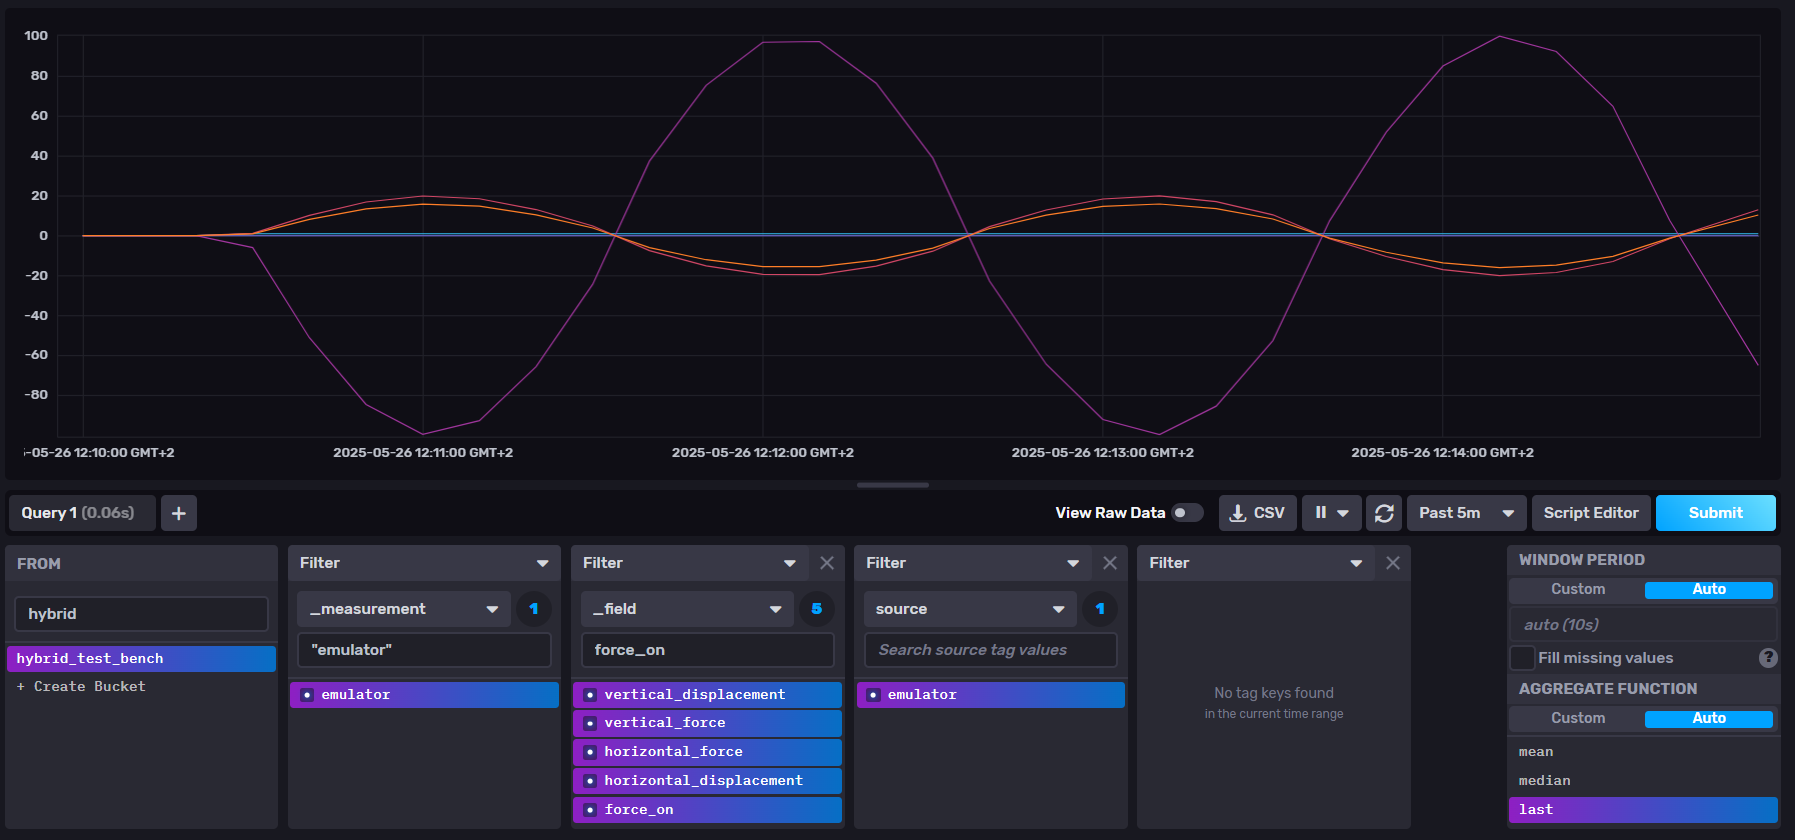

Now let's create the monitoring service script!

In [17]:
%%writefile pt_stl_monitoring_service.py

# Configure python path to load the hybrid test bench modules
import sys
import os
import logging
import logging.config
import time
from influxdb_client import InfluxDBClient
from influxdb_client.client.write_api import SYNCHRONOUS
import rtamt

# Get the current working directory. Should be hybrid-test-bench.
current_dir = os.getcwd()

assert os.path.basename(current_dir) == 'hybrid-test-bench', 'Current directory is not hybrid-test-bench'

# Get the parent directory. Should be the root of the repository
parent_dir = current_dir

# The root of the repo should contain the startup folder. Otherwise something went wrong during the inital setup.
assert os.path.exists(os.path.join(parent_dir, 'startup')), 'startup folder not found in the repository root'

# The root of the repo should contain the installation folder. Otherwise something went wrong during the inital setup.
assert os.path.exists(os.path.join(parent_dir, 'installation')), 'installation folder not found in the repository root'

bench_startup_dir = os.path.join(parent_dir, 'startup')

assert os.path.exists(bench_startup_dir), 'hybrid-test-bench startup directory not found'

# Add the parent directory to sys.path
sys.path.append(bench_startup_dir)

from communication.server.rabbitmq import Rabbitmq
from communication.shared.protocol import ROUTING_KEY_STATE, ROUTING_KEY_FORCES
import pt_model as pt_model

class PT_STLMonitoringService:

    def __init__(self, rabbitmq_config, influxdb_config):

        self._rabbitmq = Rabbitmq(**rabbitmq_config)
        
        url = influxdb_config['url']
        token = influxdb_config['token']
        self._org = influxdb_config['org']
        self._bucket = influxdb_config['bucket']

        self._client = InfluxDBClient(url=url, token=token, org=self._org)

        self._l = logging.getLogger("STLMonitoringService")

        # Specification
        self._spec = rtamt.StlDenseTimeSpecification()
        # Declare the variables that will correspond to the above signals.
        self._spec.declare_var('vertical_displacement', 'float')
        self._spec.declare_var('max_vertical_displacement', 'float')
        self._spec.spec = 'always((vertical_displacement >= max_vertical_displacement) implies (eventually[0:60](vertical_displacement <= max_vertical_displacement)))'
        self._spec.parse()

    def setup(self):
        self._rabbitmq.connect_to_server()

        # Initialize the Query API
        self._query_api = self._client.query_api()
        self._write_api = self._client.write_api(write_options=SYNCHRONOUS)

        # Subscribe to any message coming from the Hybrid Test Bench physical twin.
        self._rabbitmq.subscribe(routing_key=ROUTING_KEY_STATE,
                                on_message_callback=self.process_state_sample)

        self._l.info(f"PT_STLMonitoringService setup complete.")

    def query_influxdb(self):
        # Define your Flux query: Query the relevant forces and displacements.
        # We set a stop time of -3s to ensure that the data is aligned from the different measurements.

        flux_query = f'''
            from(bucket: "{self._bucket}")
            |> range(start: -1h, stop: -3s)
            |> filter(fn: (r) => r["_measurement"] == "emulator")
            |> filter(fn: (r) => r["_field"] == "vertical_displacement" or r["_field"] == "max_vertical_displacement")
            |> filter(fn: (r) => r["source"] == "emulator")
            |> aggregateWindow(every: 3s, fn: last, createEmpty: true)
            |> yield(name: "last")
        '''
        # Execute the query
        result = self._query_api.query(org=self._org, query=flux_query)

        vertical_displacement = []
        max_vertical_displacement = []

        for table in result:
            for record in table.records:
                ts = record.get_time().timestamp()
                if record.get_field() == 'max_vertical_displacement':
                    max_vertical_displacement.append([ts, record.get_value()])
                elif record.get_field() == 'vertical_displacement':
                    vertical_displacement.append([ts, record.get_value()])

        # Generate a time-series signal for max_vertical_displacement
        # max_vertical_displacement = [[ts, 5.0] for ts, _ in vertical_displacement]

        assert len(vertical_displacement) == len(max_vertical_displacement), 'Vertical displacement and maximum vertical displacement data not aligned.'

        return vertical_displacement, max_vertical_displacement

    def compute_robustness(self, vertical_displacement, max_vertical_displacement):
        # Evaluate rtamt on the signals and get the robustness.
        print("Evaluating rtamt on the signals.")
        robustness = self._spec.evaluate(
            ['vertical_displacement', vertical_displacement],
            ['max_vertical_displacement', max_vertical_displacement]
        )
        self._l.info(f"Robustness: {robustness}")
        return robustness
    
    def store_robustness(self, robustness):
        # Store the robustness in the InfluxDB. Duplicate records on the same timestamp will just be updated.
        records = []
        for r in robustness:
            ts = int(r[0] * 1e9)

            records.append({
                "measurement": "robustness",
                "tags": {
                    "source": "pt_stl_monitor"
                },
                "time": ts,
                "fields": {
                    "robustness": r[1]
                }
                })

        self._write_api.write(bucket=self._bucket, record=records)

    def process_state_sample(self, ch, method, properties, body_json):
        # Log the values received.
        self._l.info(f"Received state sample: {body_json}")
        
        # Get the displacement history from the influxdb, and process the displacement data into signals that ramt can understand.
        vertical_displacement, max_vertical_displacement = self.query_influxdb()

        # Evaluate ramt on the signals and get the robustness.
        robustness = self.compute_robustness(vertical_displacement, max_vertical_displacement)

        self._l.debug(f"Robustness: {robustness}")

        # Store the robustness in the InfluxDB.
        self.store_robustness(robustness)

    def start_serving(self):
        self._rabbitmq.start_consuming()

if __name__ == "__main__":
    # Get utility functions to config logging and load configuration
    from pyhocon import ConfigFactory

    # Get logging configuration
    log_conf = os.path.join(os.path.dirname(os.getcwd()), 'hybrid-test-bench', 'log.conf')
    logging.config.fileConfig(log_conf)

    # Get path to the startup.conf file used in the hybrid test bench PT & DT:
    startup_conf = os.path.join(os.path.dirname(os.getcwd()), 'hybrid-test-bench', 'software','startup.conf')
    assert os.path.exists(startup_conf), 'startup.conf file not found'

    # The startup.conf comes from the hybrid test bench repository.
    config = ConfigFactory.parse_file(startup_conf)

    service = PT_STLMonitoringService(rabbitmq_config=config["rabbitmq"], influxdb_config=config["influxdb"])

    service.setup()
    
    # Start the PT_STLMonitoringService
    service.start_serving()

Overwriting pt_stl_monitoring_service.py


We're ready to run the `python pt_stl_monitoring_service.py` script in a new terminal (in [hybrid-test-bench](../hybrid-test-bench/)), and the following robustness should be:

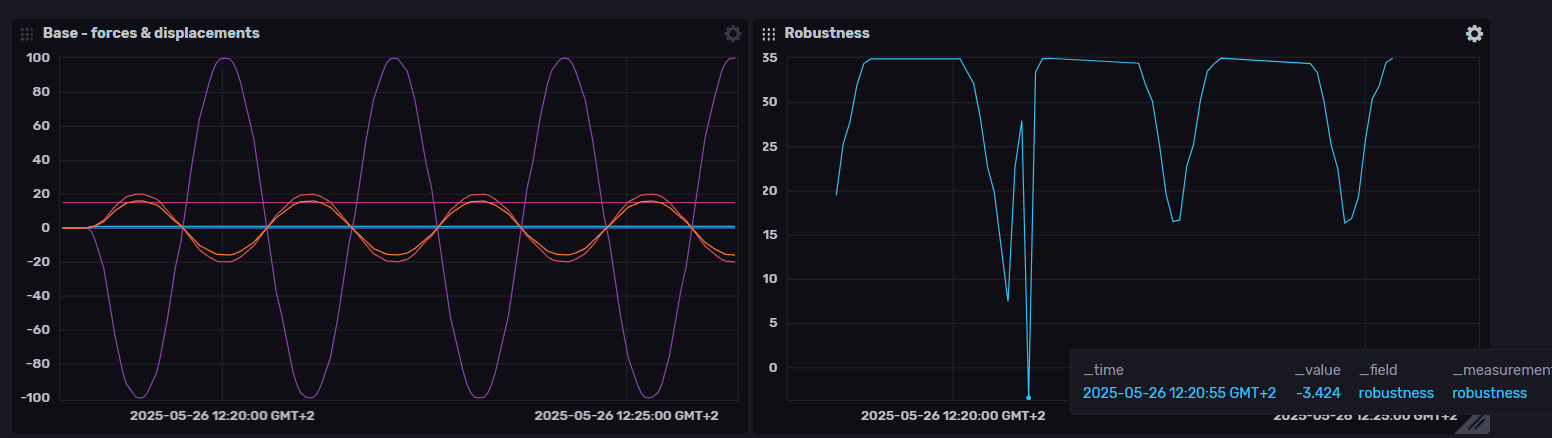

The robustness graph mirrors the sinusoidal behavior of vertical_displacement because the STL specification only checks if vertical_displacement exceeds 15.0, not if it drops below -15.0. As the signal oscillates, robustness increases when vertical_displacement moves further above 15.0 and decreases when it approaches or crosses the threshold. This explains the periodic rise and fall of robustness in sync with the signal. The robustness value becomes negative briefly, signaling us to stop applying the vertical force - for now this is only monitored, and it could also be used to implement a reconfiguration service - which we will do now.

Here we will create a reconfiguration service.

In [12]:
%%writefile pt_reconfiguration_service.py

# Configure python path to load the hybrid test bench modules
import sys
import os
import logging
import logging.config
import time
from influxdb_client import InfluxDBClient
from influxdb_client.client.write_api import SYNCHRONOUS
import rtamt

# Get the current working directory. Should be hybrid-test-bench.
current_dir = os.getcwd()

assert os.path.basename(current_dir) == 'hybrid-test-bench', 'Current directory is not hybrid-test-bench'

# Get the parent directory. Should be the root of the repository
parent_dir = current_dir

# The root of the repo should contain the startup folder. Otherwise something went wrong during the inital setup.
assert os.path.exists(os.path.join(parent_dir, 'startup')), 'startup folder not found in the repository root'

# The root of the repo should contain the installation folder. Otherwise something went wrong during the inital setup.
assert os.path.exists(os.path.join(parent_dir, 'installation')), 'installation folder not found in the repository root'

bench_startup_dir = os.path.join(parent_dir, 'startup')

assert os.path.exists(bench_startup_dir), 'hybrid-test-bench startup directory not found'

# Add the parent directory to sys.path
sys.path.append(bench_startup_dir)

from communication.server.rabbitmq import Rabbitmq
from communication.shared.protocol import ROUTING_KEY_STATE, ROUTING_KEY_FORCES

class PT_ReconfigurationService:

    def __init__(self, rabbitmq_config, influxdb_config):
        self._rabbitmq = Rabbitmq(**rabbitmq_config)
        
        url = influxdb_config['url']
        token = influxdb_config['token']
        self._org = influxdb_config['org']
        self._bucket = influxdb_config['bucket']

        self._client = InfluxDBClient(url=url, token=token, org=self._org)

        self._l = logging.getLogger("PT_ReconfigurationService")

        self._force_off_sent = False
        self._last_robustness = None
        self._start_time = time.time()
        self._grace_period = 120

    def turn_off_forces(self):
        with Rabbitmq(**config["rabbitmq"]) as rabbitmq:
            rabbitmq.send_message(ROUTING_KEY_FORCES, {"forces": False})
        self._l.info("Forces turned off. Shutting down reconfiguration service.")
        sys.exit(0) # Once we have reconfigured the system, we can exit the service.

    def check_robustness(self, robustness):
        threshold = 0.0

        if time.time() - self._start_time < self._grace_period:
            # self._l.info("Grace period active. Reconfiguration logic will start after 2 minutes.")
            return
        if not robustness:
            return

        ts, value = robustness[-1]  # Only check the latest value

        if value < threshold:
            if not self._force_off_sent:
                self.turn_off_forces()
                self._force_off_sent = True
        else:
            if self._last_robustness is not None and value < self._last_robustness:
                self._force_off_sent = False
                
        self._last_robustness = value

    def query_influxdb(self):
            # Define your Flux query: Query the relevant forces and displacements.
            # We set a stop time of -3s to ensure that the data is aligned from the different measurements.

            flux_query = f'''
                from(bucket: "{self._bucket}")
                |> range(start: -1h, stop: -3s)
                |> filter(fn: (r) => r["_measurement"] == "robustness")
                |> filter(fn: (r) => r["_field"] == "robustness")
                |> filter(fn: (r) => r["source"] == "pt_stl_monitor")
                |> aggregateWindow(every: 3s, fn: last, createEmpty: true)
                |> yield(name: "last")
            '''
            # Execute the query
            result = self._query_api.query(org=self._org, query=flux_query)

            robustness = []

            for table in result:
                for record in table.records:
                    ts = record.get_time().timestamp()
                    if record.get_field() == 'robustness':
                        robustness.append([ts, record.get_value()])

            return robustness
    
    def get_robustness(self, ch, method, properties, body_json):
    # Log the values received.
        self._l.info(f"Received state sample: {body_json}")
        
        # Get the displacement history from the influxdb, and process the displacement data into signals that ramt can understand.
        robustness = self.query_influxdb()

        # self._l.debug(f"Robustness: {robustness}")

        self.check_robustness(robustness)

    def setup(self):
            self._rabbitmq.connect_to_server()

            # Initialize the Query API
            self._query_api = self._client.query_api()
            self._write_api = self._client.write_api(write_options=SYNCHRONOUS)

            # Subscribe to any message coming from the Hybrid Test Bench physical twin.
            self._rabbitmq.subscribe(routing_key=ROUTING_KEY_STATE,
                                    on_message_callback=self.get_robustness)

            self._l.info(f"PT_ReconfigurationService setup complete.")

    def start_serving(self):
            self._rabbitmq.start_consuming()
        
if __name__ == "__main__":
    # Get utility functions to config logging and load configuration
    from pyhocon import ConfigFactory

    # Get logging configuration
    log_conf = os.path.join(os.path.dirname(os.getcwd()), 'hybrid-test-bench', 'log.conf')
    logging.config.fileConfig(log_conf)

    # Get path to the startup.conf file used in the hybrid test bench PT & DT:
    startup_conf = os.path.join(os.path.dirname(os.getcwd()), 'hybrid-test-bench', 'software','startup.conf')
    assert os.path.exists(startup_conf), 'startup.conf file not found'

    # The startup.conf comes from the hybrid test bench repository.
    config = ConfigFactory.parse_file(startup_conf)

    service = PT_ReconfigurationService(rabbitmq_config=config["rabbitmq"], influxdb_config=config["influxdb"])

    service.setup()
    
    # Start the PT_ReconfigurationService
    service.start_serving()

Overwriting pt_reconfiguration_service.py


With this we have prepared the reconfiguration service.

Run the following command in a new terminal to start the service: `python pt_reconfiguration_service.py`.

After a few minutes of the simulation services and the reconfiguration service running, we get the following graph (explanation below the image):

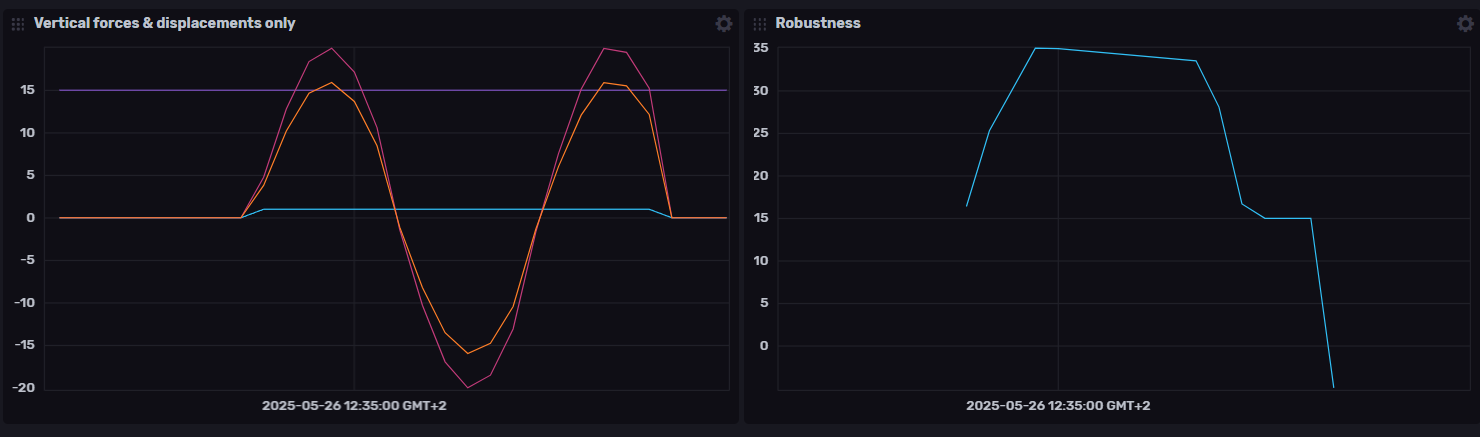

As we can see, the graphs make perfect sense! Let's try and understand them, but first let's color code the plots:

Left graph:

<ol>
    <li> (Light) Blue - force off / on (0.00 / 1.00)
    <li> Red - Vertical force
    <li> Orange - Verical displacement
    <li> Purple - Maximium vertical displacement
</ol>

Right graph:

<ol>
    <li> (Light) Blue - Robustness
</ol>

All the services running at the same time produce these two graphs - here's a brief explanation. The forces and displacements are calculated for the first few minutes, and we are keeping track of the vertical dispacement being too big, which is signaled through the robustness value (in orange). To prevent the simulation being reconfigured too soon, we added a grace period of 2 minutes, where the robustnes reaching an initial negative value doesn't turn the forces off.

On the left graph we can see that when the vertical displacement (in orange) is at a minimum (cca. -15.0), the robustness value (on the right graph) is the highest. However, once the vertical displacement becomes too big, our robustness gradually becomes smaller, and once it becomes negative, it signals us to turn off the force application. This is done automatically, seing as the reconfiguration service is used as a sort of "safe mode".

To make it very simple, once robustness becomes negative, the force application (blue) is reset, the red plot (vertical force) gradually becomes 0, and therefore the vertical displacement resets. (The horizontal force and displacement is also reset at that point, but to keep the graph a little simpler, we don't include them here).

With this we show that our Physical Twin is monitored, and when needed, automatically reconfigured into a "safe mode".

This is a very basic experiment, and doesn't make much sense - however, we will use this logic for the following section!

# 2. Deploying an STL Monitoring Service for the Digital Twin

In section 2. of this notebook, we will deploy an STL monitoring service for the DT. This time we will use identical logic, but for "tiredness" of the specimen - E modulus. This makes much more sense in real world applications.

Once again, this service will check whether the model produced - this time the [dt_model](../hybrid-test-bench/dt_model.py) - and the [actuator_controller](../hybrid-test-bench/actuator_controller.py), are working as intended. In particular, this service will run periodically, and it:
1. Queries the time series database InfluxDB to get a batch of data from running the [dt_service](../hybrid-test-bench/dt_service.py).
2. Evaluates an STL property on that specification.
3. Pushes the robustness of the specification back into InfluxDB.

Run the following code block and then follow the step-by-step instructions:

In [ ]:
# Check pre-requisite scripts are available.

import os

# Get the current working directory. Should be hybrid-test-bench.
current_dir = os.getcwd()

assert os.path.basename(current_dir) == 'hybrid-test-bench', 'Current directory is not hybrid-test-bench'

# Get the parent directory. Should be the root of the repository
parent_dir = current_dir

# Check that the various scripts are available.

path_to_check = os.path.join(parent_dir, 'start_influxdb_rabbitmq.py')
assert os.path.exists(path_to_check), f'{path_to_check} not found. Run the required notebooks in order.'

path_to_check = os.path.join(parent_dir, 'pt_emulator_service.py')
assert os.path.exists(path_to_check), f'{path_to_check} not found. Run the required notebooks in order.'

path_to_check = os.path.join(parent_dir, 'dt_service.py')
assert os.path.exists(path_to_check), f'{path_to_check} not found. Run the required notebooks in order.'

## Starting the Hybrid Test Bench

To run the services we will need to open 3 terminals and run our scripts, as well as running one code block. The log files should indicate that the services are running and have not crashed.

Follow the steps:
1. Open a terminal in [hybrid-test-bench](../hybrid-test-bench/) and run: `python start_influxdb_rabbitmq.py`

2. Open a terminal in [hybrid-test-bench](../hybrid-test-bench/) and run: `python hybrid_test_bench_data_recorder_influx.py`

3. Open a terminal in [hybrid-test-bench](../hybrid-test-bench/) and run: `python dt_service.py`

4. Run the following code block:

In [ ]:
import time

from communication.server.rabbitmq import Rabbitmq
from communication.shared.protocol import ROUTING_KEY_DT_FORCES

from pyhocon import ConfigFactory

# Get config
startup_conf = os.path.join(os.path.dirname(os.getcwd()), 'hybrid-test-bench', 'software','startup.conf')
config = ConfigFactory.parse_file(startup_conf)

# Send a message to the PT to simulate the application of a force
with Rabbitmq(**config["rabbitmq"]) as rabbitmq:
    rabbitmq.send_message(ROUTING_KEY_DT_FORCES, {"forces": True,
                                               "horizontal_force": 100,
                                               "vertical_displacement": 20,
                                               "horizontal_period": 2.0,
                                               "vertical_period": 2.0})

# Wait a bit for the message to be processed
time.sleep(5)

## Deploying the Monitor

The service below queries a batch of data from the past 1h in InfluxDB, and checks when the E modulus drops below the minimum value.

After running the previous commands, and waiting a few minutes, we can see a graph showing E modulus and the minimum E modules - which is 50.000. This is used to perform the STL evaluation.

To-do: Delete this, after we fix it. At the moment the min_e_modulus is set to 99.000; adjust accordingly.

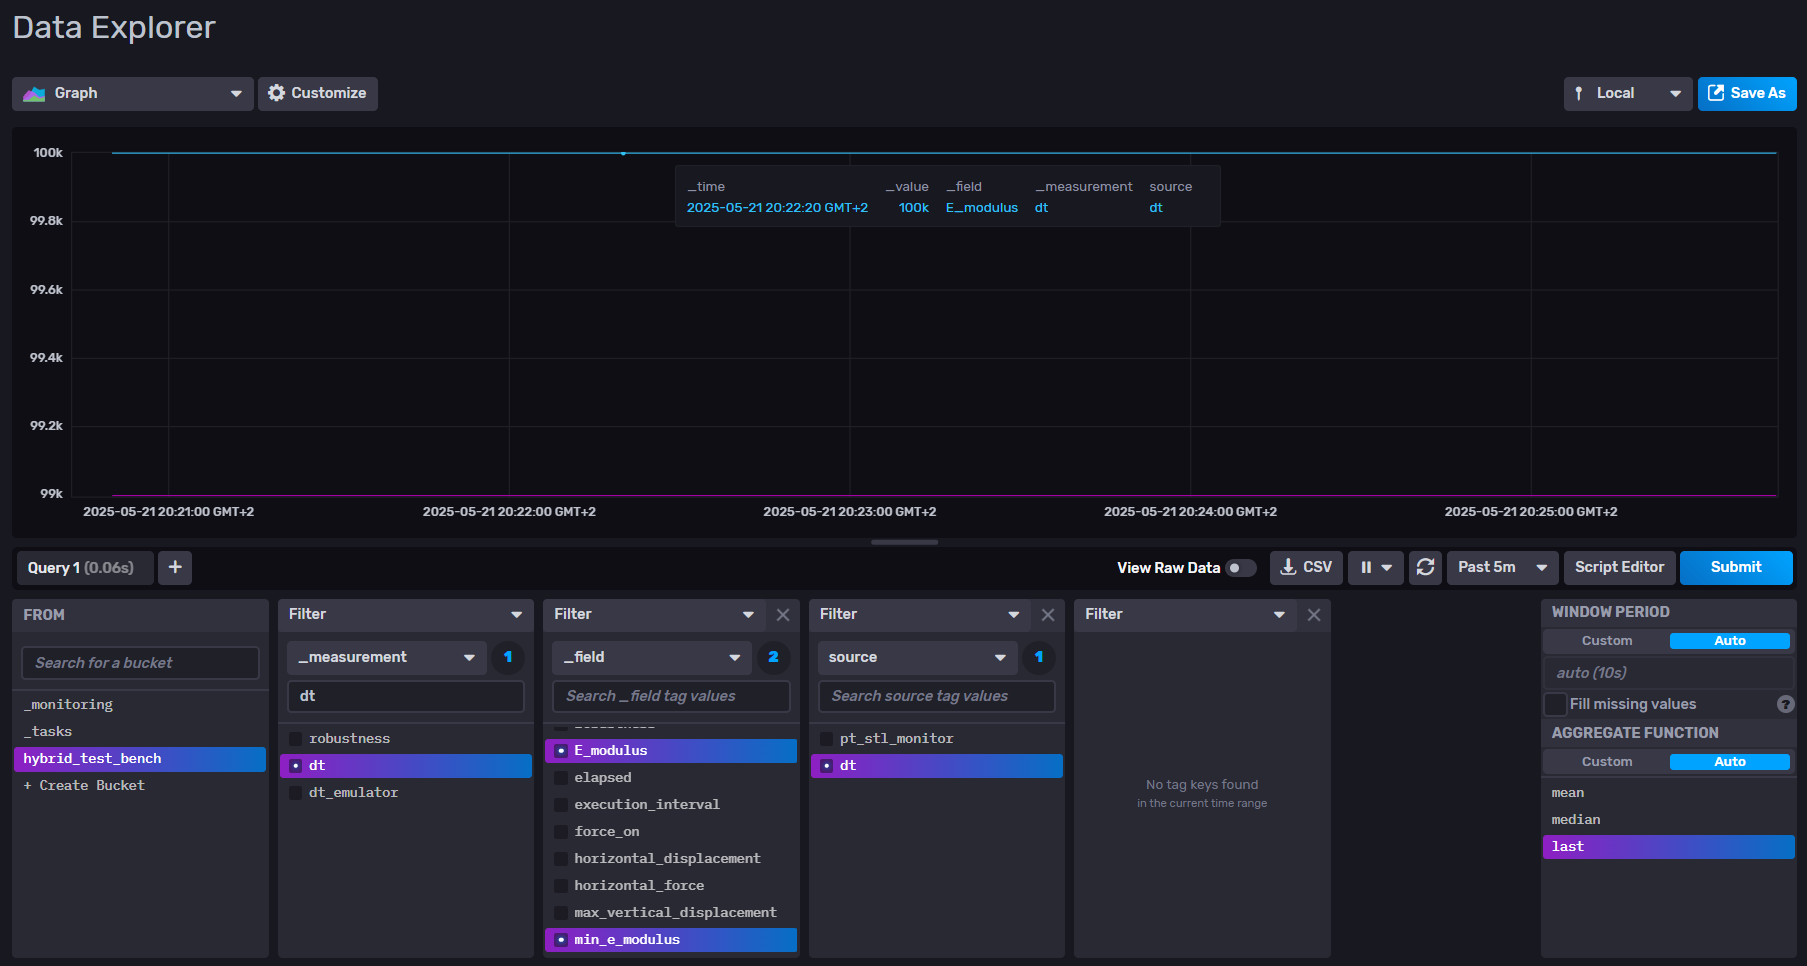

Now let's create the monitoring service script!

In [19]:
%%writefile dt_stl_monitoring_service.py

# Configure python path to load the hybrid test bench modules
import sys
import os
import logging
import logging.config
import time
from influxdb_client import InfluxDBClient
from influxdb_client.client.write_api import SYNCHRONOUS
import rtamt

# Get the current working directory. Should be hybrid-test-bench.
current_dir = os.getcwd()

assert os.path.basename(current_dir) == 'hybrid-test-bench', 'Current directory is not hybrid-test-bench'

# Get the parent directory. Should be the root of the repository
parent_dir = current_dir

# The root of the repo should contain the startup folder. Otherwise something went wrong during the inital setup.
assert os.path.exists(os.path.join(parent_dir, 'startup')), 'startup folder not found in the repository root'

# The root of the repo should contain the installation folder. Otherwise something went wrong during the inital setup.
assert os.path.exists(os.path.join(parent_dir, 'installation')), 'installation folder not found in the repository root'

bench_startup_dir = os.path.join(parent_dir, 'startup')

assert os.path.exists(bench_startup_dir), 'hybrid-test-bench startup directory not found'

# Add the parent directory to sys.path
sys.path.append(bench_startup_dir)

from communication.server.rabbitmq import Rabbitmq
from communication.shared.protocol import ROUTING_KEY_STATE, ROUTING_KEY_DT_FORCES
import dt_model as dt_model

class DT_STLMonitoringService:

    def __init__(self, rabbitmq_config, influxdb_config):

        self._rabbitmq = Rabbitmq(**rabbitmq_config)
        
        url = influxdb_config['url']
        token = influxdb_config['token']
        self._org = influxdb_config['org']
        self._bucket = influxdb_config['bucket']

        self._client = InfluxDBClient(url=url, token=token, org=self._org)

        self._l = logging.getLogger("STLMonitoringService")

        # Specification
        self._spec = rtamt.StlDenseTimeSpecification()
        # Declare the variables that will correspond to the above signals.
        self._spec.declare_var('E_modulus', 'float')
        self._spec.declare_var('min_e_modulus', 'float')
        self._spec.spec = 'always((E_modulus <= min_e_modulus) implies (eventually[0:60](E_modulus >= min_e_modulus)))'
        self._spec.parse()

    def setup(self):
        self._rabbitmq.connect_to_server()

        # Initialize the Query API
        self._query_api = self._client.query_api()
        self._write_api = self._client.write_api(write_options=SYNCHRONOUS)

        # Subscribe to any message coming from the Hybrid Test Bench digital twin.
        self._rabbitmq.subscribe(routing_key=ROUTING_KEY_STATE,
                                on_message_callback=self.process_state_sample)

        self._l.info(f"DT_STLMonitoringService setup complete.")

    def query_influxdb(self):
        # We set a stop time of -3s to ensure that the data is aligned from the different measurements.

        flux_query = f'''
            from(bucket: "{self._bucket}")
            |> range(start: -1h, stop: -3s)
            |> filter(fn: (r) => r["_measurement"] == "dt")
            |> filter(fn: (r) => r["_field"] == "E_modulus" or r["_field"] == "min_e_modulus")
            |> filter(fn: (r) => r["source"] == "dt")
            |> aggregateWindow(every: 3s, fn: last, createEmpty: true)
            |> yield(name: "last")
        '''
        # Execute the query
        result = self._query_api.query(org=self._org, query=flux_query)

        e_modulus = []
        min_e_modulus = []

        for table in result:
            for record in table.records:
                ts = record.get_time().timestamp()
                if record.get_field() == 'min_e_modulus':
                    min_e_modulus.append([ts, record.get_value()])
                elif record.get_field() == 'E_modulus':
                    e_modulus.append([ts, record.get_value()])

        # Align the two signals by timestamp
        e_modulus_dict = dict(e_modulus)
        min_e_modulus_dict = dict(min_e_modulus)
        common_ts = sorted(set(e_modulus_dict.keys()) & set(min_e_modulus_dict.keys()))
        aligned_e_modulus = [[ts, e_modulus_dict[ts]] for ts in common_ts]
        aligned_min_e_modulus = [[ts, min_e_modulus_dict[ts]] for ts in common_ts]
    
        assert len(aligned_e_modulus) == len(aligned_min_e_modulus), 'E_modulus and minimum e_modulus data not aligned.'

        return aligned_e_modulus, aligned_min_e_modulus

    def compute_robustness(self, e_modulus, min_e_modulus):
        # Evaluate rtamt on the signals and get the robustness.
        print("Evaluating rtamt on the signals.")
        robustness = self._spec.evaluate(
            ['E_modulus', e_modulus],
            ['min_e_modulus', min_e_modulus]
        )
        self._l.info(f"Robustness: {robustness}")
        return robustness
    
    def store_robustness(self, robustness):
        # Store the robustness in the InfluxDB. Duplicate records on the same timestamp will just be updated.
        records = []
        for r in robustness:
            ts = int(r[0] * 1e9)

            records.append({
                "measurement": "robustness",
                "tags": {
                    "source": "dt_stl_monitor"
                },
                "time": ts,
                "fields": {
                    "robustness": r[1]
                }
                })

        self._write_api.write(bucket=self._bucket, record=records)

    def process_state_sample(self, ch, method, properties, body_json):
        # Log the values received.
        self._l.info(f"Received state sample: {body_json}")
        
        # Get the displacement history from the influxdb, and process the e_modulus data into signals that ramt can understand.
        e_modulus, min_e_modulus = self.query_influxdb()

        # Evaluate ramt on the signals and get the robustness.
        robustness = self.compute_robustness(e_modulus, min_e_modulus)

        self._l.debug(f"Robustness: {robustness}")

        # Store the robustness in the InfluxDB.
        self.store_robustness(robustness)

    def start_serving(self):
        self._rabbitmq.start_consuming()

if __name__ == "__main__":
    # Get utility functions to config logging and load configuration
    from pyhocon import ConfigFactory

    # Get logging configuration
    log_conf = os.path.join(os.path.dirname(os.getcwd()), 'hybrid-test-bench', 'log.conf')
    logging.config.fileConfig(log_conf)

    # Get path to the startup.conf file used in the hybrid test bench PT & DT:
    startup_conf = os.path.join(os.path.dirname(os.getcwd()), 'hybrid-test-bench', 'software','startup.conf')
    assert os.path.exists(startup_conf), 'startup.conf file not found'

    # The startup.conf comes from the hybrid test bench repository.
    config = ConfigFactory.parse_file(startup_conf)

    service = DT_STLMonitoringService(rabbitmq_config=config["rabbitmq"], influxdb_config=config["influxdb"])

    service.setup()
    
    # Start the DT_STLMonitoringService
    service.start_serving()

Overwriting dt_stl_monitoring_service.py



Now we're ready to run the `python dt_stl_monitoring_service.py` script in a new terminal (in [hybrid-test-bench](../hybrid-test-bench/)), and the following robustness should be:

To-do: Insert image here

The robustness graph...

With this in mind we can now focus on creating a reconfiguration service for the e_modulus.

In [13]:
# With this in mind we can now focus on creating the dt_reconfiguration_service.py script. 
# This script will be responsible for turning off the forces application, after the minimum e_modulus is exceeded.